<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/APTorch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the first half of the notebook we will discuss:

1.
Primary setup of Rnn architecture
2. Experiment with RNN on a few text based use cases

## Application of RNN for classification

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext import data
from torchtext import datasets
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torchsummary import summary
from torchview import draw_graph
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 10
lr = 1e-3

Random seed set as 42
cuda


In [6]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


#### DataPrep- Same process as that of session-4

In [7]:
# get train and testset
train_dataset, test_dataset  = datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [8]:
# we wil use advanced tokenizer provided by torch
tokenizer = get_tokenizer("basic_english")
print(tokenizer("You can now install TorchText using pip!"))

['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']


In [9]:
def build_vocab_iter(datasets):
  """yields tokenized text """
  for dataset in datasets:
    for _, text in dataset:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab_iter([train_dataset, test_dataset]), specials=["<unk>"]) # build vocab from an iterator
vocab.set_default_index(vocab["<unk>"]) # anything unk will be have a default index

#### Dataloader

In [11]:
def vectorize_batch(batch):
  """Vectorize the batch and used in dataloader"""
  Y,X  = list(zip(*batch))
  X=[vocab(tokenizer(sample)) for sample in X]
  X = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X] ## Bringing all samples to 50 length ie standardization of length
  Y = [0 if y==0 else y-1 for y in Y] # converting label starting form 0
  return torch.tensor(X, dtype=torch.int64).to(device), torch.tensor(Y, dtype=torch.int64).to(device)

In [73]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, collate_fn=vectorize_batch)

In [74]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


#### Basic RNN Classifier

This section describes the construction of a neural network for text classification, comprising three layers:

Embeddings Layer: This layer maps input token indexes to embedding vectors. The embeddings have a length of 50, meaning each token is represented by a 50-dimensional vector. During training, these embeddings are updated to improve document classification. The input shape is (batch_size, 25), and the output shape is (batch_size, 25, 50).

RNN Layer: Taking input from the embedding layer, this recurrent layer processes sequences of embeddings and generates outputs that encode contextual information about the text. It operates on the input shape of (batch_size, 25, 50) and produces an output shape of (batch_size, 25, hidden_size), where the hidden_size is set to 50 in this example. The RNN layer iterates through each token's embedding, producing an output that becomes the input for the next token. The initial state for each example is provided, typically as random numbers, and this process repeats for each text example.

Linear Layer: Finally, the output of the RNN layer is fed into a linear layer with four output units, corresponding to the number of target classes. Only the last output of each example (output[:,-1]) is used because the RNN layer contains information about all previous tokens. Thus, the input shape for the linear layer is (batch_size, 50). The RNN output shape of (batch_size, 25, 50) is transformed to (batch_size, 50) to fit the linear layer input.

The entire process involves sequential processing of embeddings through the RNN layer, with the final output used for classification. PyTorch's 'nn' submodule provides constructors like RNN() to create recurrent layers, allowing customization of input shape, hidden dimensions, and the number of layers.

In [95]:
# basic config
n_embedding = 100
n_hidden = 50
n_layers = 1

In [111]:
class BasicRnnClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):

    super(BasicRnnClassifier, self).__init__()
    self.embedding = nn.Embedding(len(vocab), embedding_dim)
    self.dropout = nn.Dropout(0.1)
    self.rnn = nn.RNN(input_size = embedding_dim , hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)


  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)
    x, hidden = self.rnn(x, torch.randn(n_layers, len(X_batch), n_hidden).to(device) ) #(1,1024,50)
    x = self.fc(x[:,-1]) # we only need the last op
    return x



In [112]:
basic_rnn = BasicRnnClassifier(n_embedding, n_hidden, len(target_classes), n_layers)
basic_rnn = basic_rnn.to(device)

In [113]:
# input_batch = torch.randint(0, len(vocab), (batch_size, 50)).long().to(device)  # Convert to Long type and move to device
# summary(basic_rnn, input_batch.unsqueeze(0).shape,1)

In [114]:
for layer in basic_rnn.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print("\n")

Layer : Embedding(98635, 100)
Parameters : 
torch.Size([98635, 100])


Layer : Dropout(p=0.1, inplace=False)
Parameters : 


Layer : RNN(100, 50, batch_first=True)
Parameters : 
torch.Size([50, 100])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])


Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])




In [115]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=-1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [116]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=-1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [117]:
# driver setup
optimizer = optim.Adam(basic_rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [118]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(basic_rnn, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(basic_rnn, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3899785845966663 Avg Train Metric: 0.2593719348058862: 100%|██████████| 118/118 [00:06<00:00, 18.87it/s]
Avg Test Loss: 1.380949005484581 Avg Test Metric: 0.28657473251223564: 100%|██████████| 8/8 [00:00<00:00, 25.91it/s]


Epoch 1


Avg Train Loss: 1.366701602935791 Avg Train Metric: 0.2815747516135038: 100%|██████████| 118/118 [00:06<00:00, 17.14it/s]
Avg Test Loss: 1.2928835153579712 Avg Test Metric: 0.39411113783717155: 100%|██████████| 8/8 [00:00<00:00, 25.07it/s]


Epoch 2


Avg Train Loss: 1.2855943138316526 Avg Train Metric: 0.3884038084139258: 100%|██████████| 118/118 [00:06<00:00, 19.10it/s]
Avg Test Loss: 1.244664341211319 Avg Test Metric: 0.41539928689599037: 100%|██████████| 8/8 [00:00<00:00, 26.30it/s]


Epoch 3


Avg Train Loss: 1.185162188643116 Avg Train Metric: 0.43512835921877524: 100%|██████████| 118/118 [00:06<00:00, 17.00it/s]
Avg Test Loss: 1.1547832190990448 Avg Test Metric: 0.4477427043020725: 100%|██████████| 8/8 [00:00<00:00, 25.73it/s]


Epoch 4


Avg Train Loss: 1.1242564300359306 Avg Train Metric: 0.46315012316582566: 100%|██████████| 118/118 [00:06<00:00, 18.06it/s]
Avg Test Loss: 1.120209977030754 Avg Test Metric: 0.4692486561834812: 100%|██████████| 8/8 [00:00<00:00, 14.74it/s]


Epoch 5


Avg Train Loss: 1.1016887921397969 Avg Train Metric: 0.47643790583489304: 100%|██████████| 118/118 [00:06<00:00, 18.37it/s]
Avg Test Loss: 1.0875414460897446 Avg Test Metric: 0.49307648837566376: 100%|██████████| 8/8 [00:00<00:00, 24.93it/s]


Epoch 6


Avg Train Loss: 1.0682156045558089 Avg Train Metric: 0.49037729557287896: 100%|██████████| 118/118 [00:06<00:00, 17.10it/s]
Avg Test Loss: 1.1038935035467148 Avg Test Metric: 0.47640182450413704: 100%|██████████| 8/8 [00:00<00:00, 26.24it/s]


Epoch 7


Avg Train Loss: 1.0434399898779594 Avg Train Metric: 0.5042516793739997: 100%|██████████| 118/118 [00:06<00:00, 18.14it/s]
Avg Test Loss: 1.0285944417119026 Avg Test Metric: 0.512342780828476: 100%|██████████| 8/8 [00:00<00:00, 25.94it/s]


Epoch 8


Avg Train Loss: 0.9922537460165509 Avg Train Metric: 0.5267059818162756: 100%|██████████| 118/118 [00:07<00:00, 16.80it/s]
Avg Test Loss: 1.0229881256818771 Avg Test Metric: 0.5027916133403778: 100%|██████████| 8/8 [00:00<00:00, 23.49it/s]


Epoch 9


Avg Train Loss: 0.959858583696818 Avg Train Metric: 0.5381742533990892: 100%|██████████| 118/118 [00:06<00:00, 17.89it/s]
Avg Test Loss: 1.01383126527071 Avg Test Metric: 0.5204467326402664: 100%|██████████| 8/8 [00:00<00:00, 15.87it/s]


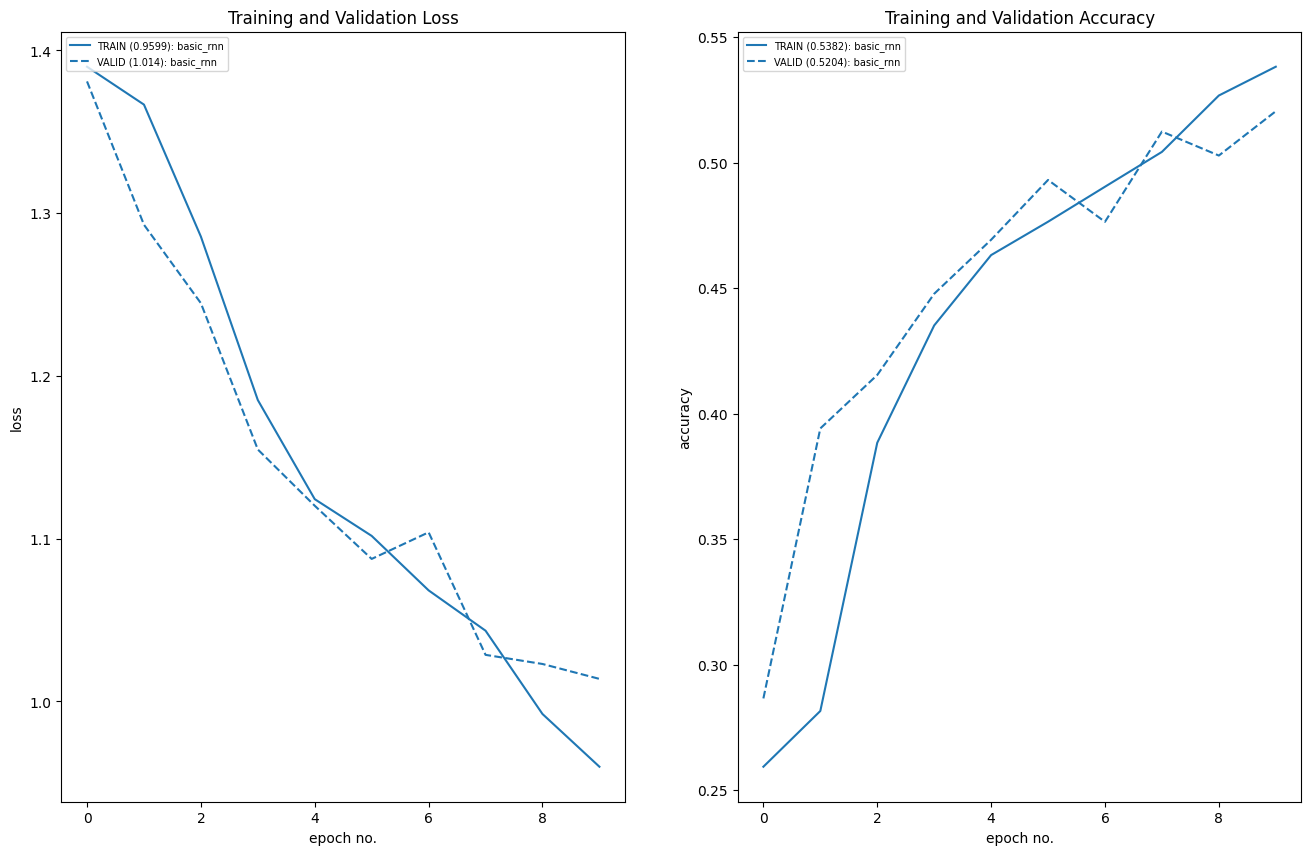

In [119]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['basic_rnn'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [120]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

In [121]:
Y_actual, Y_preds = MakePredictions(basic_rnn, test_loader)

In [122]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.5223684210526316

Classification Report : 
              precision    recall  f1-score   support

       World       0.47      0.12      0.20      1900
      Sports       0.84      0.92      0.88      1900
    Business       0.38      0.86      0.53      1900
    Sci/Tech       0.47      0.18      0.26      1900

    accuracy                           0.52      7600
   macro avg       0.54      0.52      0.47      7600
weighted avg       0.54      0.52      0.47      7600


Confusion Matrix : 
[[ 234  114 1363  189]
 [  12 1753   52   83]
 [ 115   37 1643  105]
 [ 138  174 1248  340]]


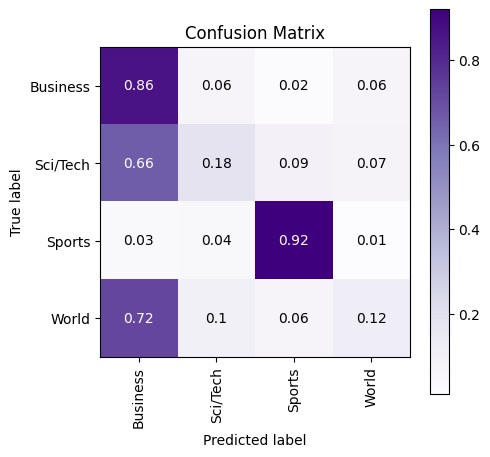

In [123]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Multiple RNN Layers
In this section, the approach involves enhancing the network architecture by stacking three recurrent layers instead of just one, aiming to improve the classification of text documents. The code remains largely similar to previous approaches, with minor adjustments, primarily setting the num_layers parameter of the RNN() constructor to 3 to indicate the stacking of three recurrent layers.

In [ ]:
n_layers=3

In [124]:
class StackedRnnClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):

    super(StackedRnnClassifier, self).__init__()
    self.embedding = nn.Embedding(len(vocab), embedding_dim)
    self.dropout = nn.Dropout(0.1)
    self.rnn = nn.RNN(input_size = embedding_dim , hidden_size = hidden_dim, num_layers = n_layers, batch_first = True, dropout=0.1)
    self.fc = nn.Linear(hidden_dim, output_dim)


  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)
    x, hidden = self.rnn(x, torch.randn(n_layers, len(X_batch), n_hidden).to(device) ) #(3,1024,50)
    x = self.fc(x[:,-1]) # we only need the last op
    return x



In [125]:
stacked_rnn = StackedRnnClassifier(n_embedding, n_hidden, len(target_classes), n_layers)
stacked_rnn = stacked_rnn.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [126]:
# driver setup
optimizer = optim.Adam(stacked_rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [127]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(stacked_rnn, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(stacked_rnn, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3883828399545055 Avg Train Metric: 0.26219539925203483: 100%|██████████| 118/118 [00:06<00:00, 17.39it/s]
Avg Test Loss: 1.3821589350700378 Avg Test Metric: 0.25515376776456833: 100%|██████████| 8/8 [00:00<00:00, 24.88it/s]


Epoch 1


Avg Train Loss: 1.3697120193707741 Avg Train Metric: 0.283811950835131: 100%|██████████| 118/118 [00:06<00:00, 18.55it/s]
Avg Test Loss: 1.2830786556005478 Avg Test Metric: 0.3911219947040081: 100%|██████████| 8/8 [00:00<00:00, 16.18it/s]


Epoch 2


Avg Train Loss: 1.241903627322892 Avg Train Metric: 0.4052737107721426: 100%|██████████| 118/118 [00:06<00:00, 18.03it/s]
Avg Test Loss: 1.1919779181480408 Avg Test Metric: 0.4188004471361637: 100%|██████████| 8/8 [00:00<00:00, 26.22it/s]


Epoch 3


Avg Train Loss: 1.1988597653679929 Avg Train Metric: 0.41813551419872347: 100%|██████████| 118/118 [00:06<00:00, 17.16it/s]
Avg Test Loss: 1.1597080528736115 Avg Test Metric: 0.45688890665769577: 100%|██████████| 8/8 [00:00<00:00, 26.95it/s]


Epoch 4


Avg Train Loss: 1.1267338253683963 Avg Train Metric: 0.4650548880888244: 100%|██████████| 118/118 [00:06<00:00, 18.61it/s]
Avg Test Loss: 1.0868922621011734 Avg Test Metric: 0.49140095710754395: 100%|██████████| 8/8 [00:00<00:00, 27.01it/s]


Epoch 5


Avg Train Loss: 1.0642059627225844 Avg Train Metric: 0.49164744504427504: 100%|██████████| 118/118 [00:06<00:00, 17.25it/s]
Avg Test Loss: 0.9602923020720482 Avg Test Metric: 0.5992490947246552: 100%|██████████| 8/8 [00:00<00:00, 23.69it/s]


Epoch 6


Avg Train Loss: 0.989888458938922 Avg Train Metric: 0.5819160205832983: 100%|██████████| 118/118 [00:06<00:00, 18.55it/s]
Avg Test Loss: 1.0738595724105835 Avg Test Metric: 0.5368870496749878: 100%|██████████| 8/8 [00:00<00:00, 26.12it/s]


Epoch 7


Avg Train Loss: 1.1046740200559972 Avg Train Metric: 0.47233503652831255: 100%|██████████| 118/118 [00:06<00:00, 17.35it/s]
Avg Test Loss: 1.09860298037529 Avg Test Metric: 0.47545723617076874: 100%|██████████| 8/8 [00:00<00:00, 26.73it/s]


Epoch 8


Avg Train Loss: 1.1036646406529314 Avg Train Metric: 0.47390675317432923: 100%|██████████| 118/118 [00:07<00:00, 16.85it/s]
Avg Test Loss: 1.0802710205316544 Avg Test Metric: 0.47261881828308105: 100%|██████████| 8/8 [00:00<00:00, 25.99it/s]


Epoch 9


Avg Train Loss: 1.0604024337509932 Avg Train Metric: 0.48108855091919334: 100%|██████████| 118/118 [00:06<00:00, 19.13it/s]
Avg Test Loss: 1.0550766587257385 Avg Test Metric: 0.49178215488791466: 100%|██████████| 8/8 [00:00<00:00, 25.58it/s]


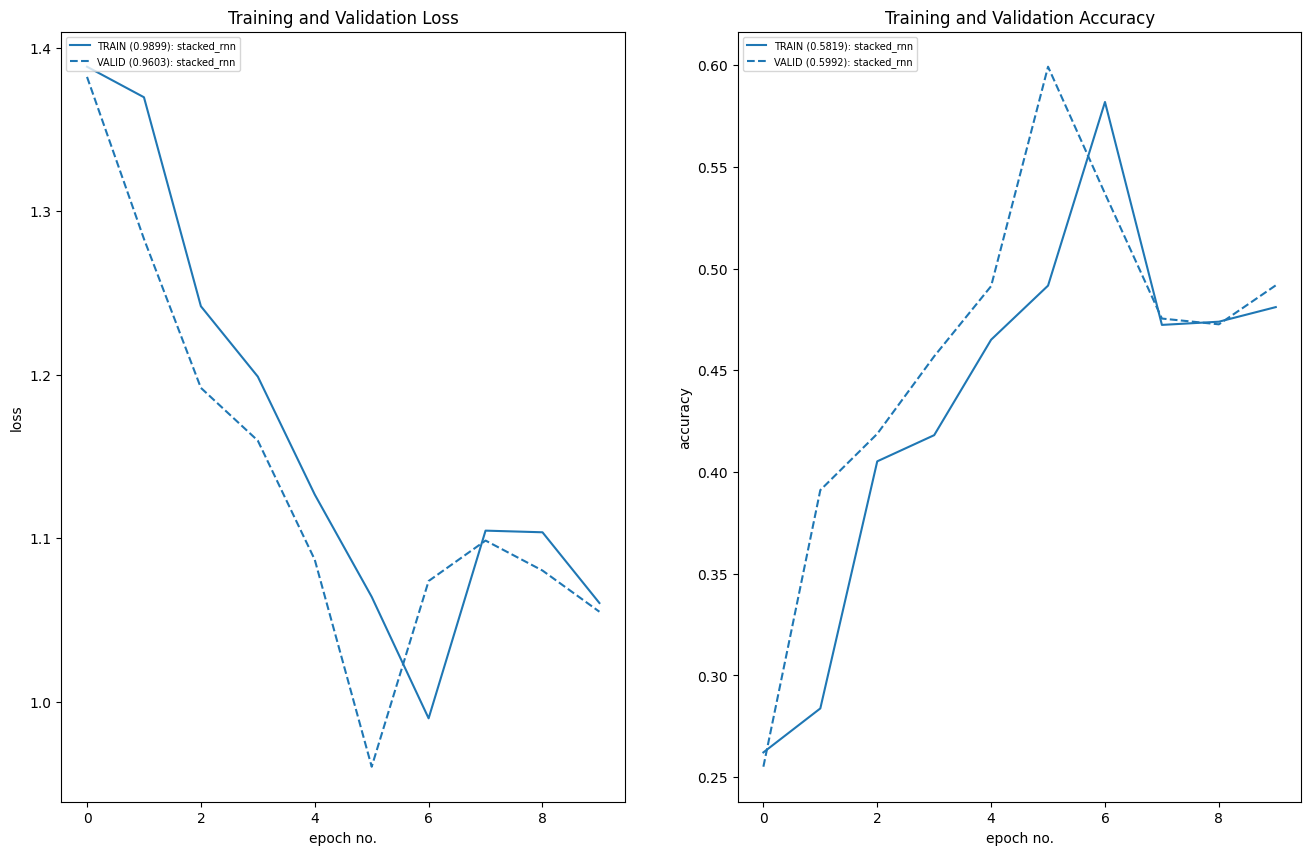

In [128]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['stacked_rnn'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [139]:
Y_actual, Y_preds = MakePredictions(stacked_rnn, test_loader)

In [140]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.4831578947368421

Classification Report : 
              precision    recall  f1-score   support

       World       0.44      0.10      0.16      1900
      Sports       0.83      0.86      0.84      1900
    Business       0.40      0.22      0.29      1900
    Sci/Tech       0.34      0.75      0.47      1900

    accuracy                           0.48      7600
   macro avg       0.50      0.48      0.44      7600
weighted avg       0.50      0.48      0.44      7600


Confusion Matrix : 
[[ 188  162  314 1236]
 [  53 1637   35  175]
 [  90   71  424 1315]
 [  95  105  277 1423]]


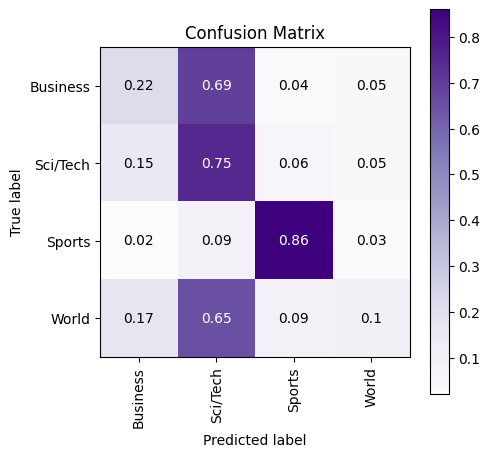

In [141]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Multiple Bidirectional RNN Layers
In this section, the approach mirrors the third one, utilizing three recurrent layers with the same output size. However, the key difference lies in the use of bidirectional recurrent layers. These layers operate both in the forward and backward directions through the input sequence. Consequently, when applied to a sequence of 50 tokens, the bidirectional recurrent layer processes both directions, effectively resulting in an output shape twice that of a unidirectional layer, as it outputs for both directions. The code remains largely unchanged from the third approach, with only minor adjustments to parameter values.

In [132]:
class BiStackeRnnClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):

    super(BiStackeRnnClassifier, self).__init__()
    self.embedding = nn.Embedding(len(vocab), embedding_dim)
    self.dropout = nn.Dropout(0.1)
    self.rnn = nn.RNN(input_size = embedding_dim , hidden_size = hidden_dim, num_layers = n_layers, batch_first = True, bidirectional=True)
    self.fc = nn.Linear(2*hidden_dim, output_dim)  # due to bidirectional we mul by 2


  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)
    x, hidden = self.rnn(x, torch.randn(2*n_layers, len(X_batch), n_hidden).to(device) ) #(6,1024,50)
    x = self.fc(x[:,-1]) # we only need the last op
    return x



In [133]:
bi_stacked_rnn = BiStackeRnnClassifier(n_embedding, n_hidden, len(target_classes), n_layers)
bi_stacked_rnn = bi_stacked_rnn.to(device)

In [134]:
# driver setup
optimizer = optim.Adam(bi_stacked_rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [135]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(bi_stacked_rnn, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(bi_stacked_rnn, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3886007535255562 Avg Train Metric: 0.25896316046937035: 100%|██████████| 118/118 [00:08<00:00, 14.16it/s]
Avg Test Loss: 1.3682014495134354 Avg Test Metric: 0.30990203097462654: 100%|██████████| 8/8 [00:00<00:00, 15.50it/s]


Epoch 1


Avg Train Loss: 1.2646127939224243 Avg Train Metric: 0.3695374477212712: 100%|██████████| 118/118 [00:07<00:00, 15.88it/s]
Avg Test Loss: 1.216605320572853 Avg Test Metric: 0.41028740629553795: 100%|██████████| 8/8 [00:00<00:00, 26.32it/s]


Epoch 2


Avg Train Loss: 1.1964112237348394 Avg Train Metric: 0.42154300566446984: 100%|██████████| 118/118 [00:07<00:00, 16.37it/s]
Avg Test Loss: 1.1455833464860916 Avg Test Metric: 0.4484221190214157: 100%|██████████| 8/8 [00:00<00:00, 25.72it/s]


Epoch 3


Avg Train Loss: 1.1997800368373677 Avg Train Metric: 0.44006524449687895: 100%|██████████| 118/118 [00:07<00:00, 15.78it/s]
Avg Test Loss: 1.1841080039739609 Avg Test Metric: 0.4376540184020996: 100%|██████████| 8/8 [00:00<00:00, 25.85it/s]


Epoch 4


Avg Train Loss: 1.142285872313936 Avg Train Metric: 0.43919321263240557: 100%|██████████| 118/118 [00:07<00:00, 15.66it/s]
Avg Test Loss: 1.1350833773612976 Avg Test Metric: 0.45518114790320396: 100%|██████████| 8/8 [00:00<00:00, 25.25it/s]


Epoch 5


Avg Train Loss: 1.1060673665192167 Avg Train Metric: 0.4592644243927325: 100%|██████████| 118/118 [00:06<00:00, 17.40it/s]
Avg Test Loss: 1.141491174697876 Avg Test Metric: 0.4477190040051937: 100%|██████████| 8/8 [00:00<00:00, 24.36it/s]


Epoch 6


Avg Train Loss: 1.0897419583999504 Avg Train Metric: 0.45500395813230743: 100%|██████████| 118/118 [00:07<00:00, 15.75it/s]
Avg Test Loss: 1.0667519122362137 Avg Test Metric: 0.4625026285648346: 100%|██████████| 8/8 [00:00<00:00, 25.35it/s]


Epoch 7


Avg Train Loss: 1.0464228507825883 Avg Train Metric: 0.482879116120985: 100%|██████████| 118/118 [00:07<00:00, 15.71it/s]
Avg Test Loss: 1.0711190849542618 Avg Test Metric: 0.48745501041412354: 100%|██████████| 8/8 [00:00<00:00, 15.77it/s]


Epoch 8


Avg Train Loss: 1.0457260103548986 Avg Train Metric: 0.48270768558574934: 100%|██████████| 118/118 [00:07<00:00, 16.50it/s]
Avg Test Loss: 1.035335049033165 Avg Test Metric: 0.47839128226041794: 100%|██████████| 8/8 [00:00<00:00, 26.21it/s]


Epoch 9


Avg Train Loss: 1.0129757129539878 Avg Train Metric: 0.4918635694657342: 100%|██████████| 118/118 [00:07<00:00, 15.88it/s]
Avg Test Loss: 1.0479610487818718 Avg Test Metric: 0.47806110605597496: 100%|██████████| 8/8 [00:00<00:00, 24.97it/s]


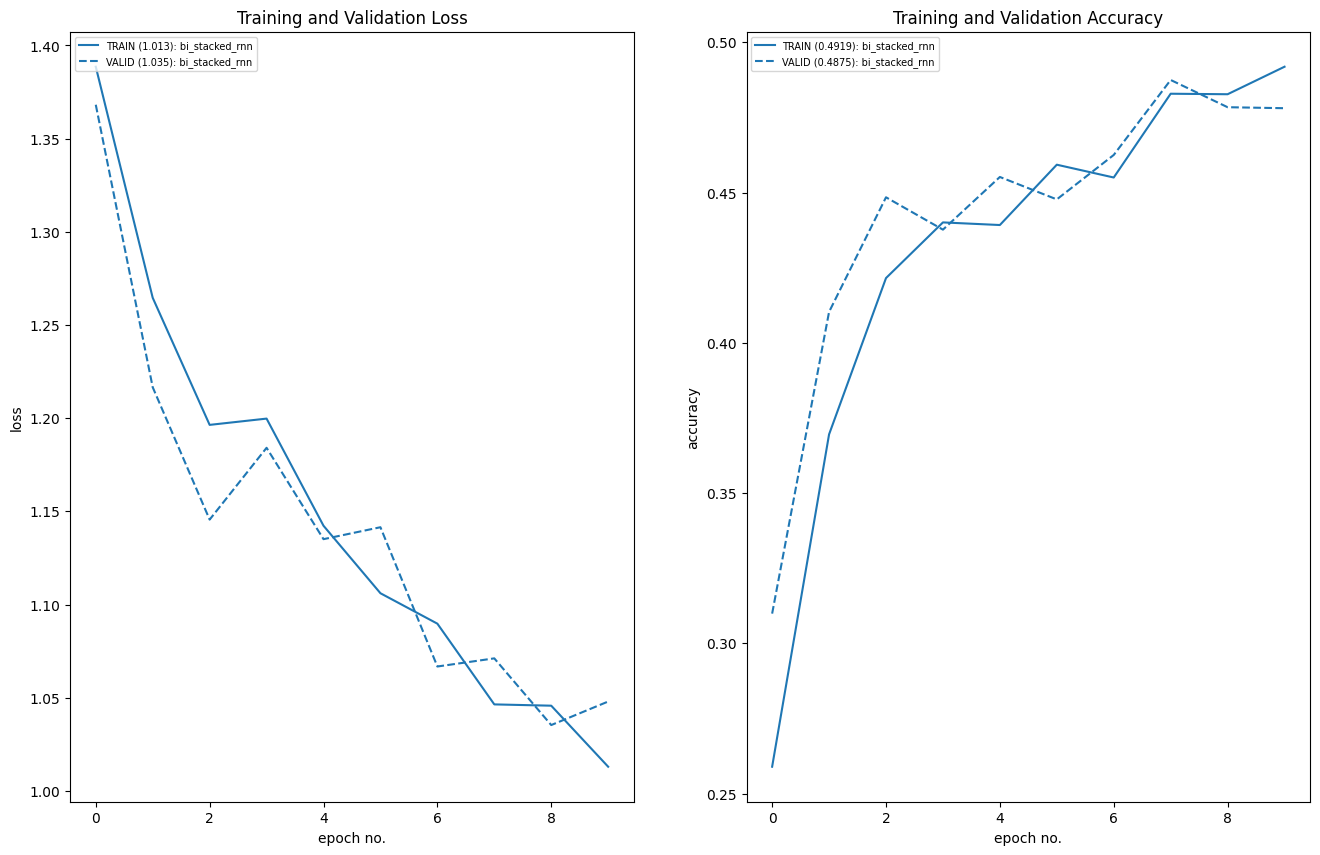

In [136]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['bi_stacked_rnn'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [142]:
Y_actual, Y_preds = MakePredictions(bi_stacked_rnn, test_loader)

In [143]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.48447368421052633

Classification Report : 
              precision    recall  f1-score   support

       World       0.40      0.12      0.18      1900
      Sports       0.83      0.91      0.87      1900
    Business       0.34      0.86      0.49      1900
    Sci/Tech       0.43      0.05      0.09      1900

    accuracy                           0.48      7600
   macro avg       0.50      0.48      0.41      7600
weighted avg       0.50      0.48      0.41      7600


Confusion Matrix : 
[[ 228  164 1443   65]
 [  27 1736  132    5]
 [ 140   81 1628   51]
 [ 175  113 1522   90]]


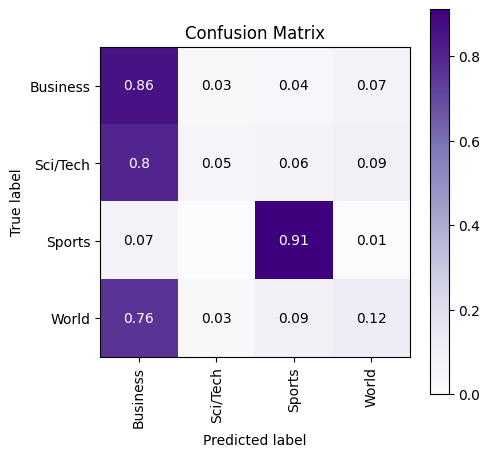

In [144]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);